In [12]:
import networkx as nx
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
import numpy as np
import matplotlib
import re
from sklearn import metrics

%matplotlib inline

Generate a very simple classification task:

X with 3 features following a uniform dist.
Y labels for values greater .7 for each feature

In [13]:
numTrainSamples = 10000
numTestSamples = 3000
numFeatures = 3
thresh = .5
X_train = np.random.rand(numTrainSamples,numFeatures)
Y_train = np.all(X_train>thresh,axis=1)

X_test = np.random.rand(numTestSamples,numFeatures)
Y_test = np.all(X_test>thresh,axis=1)

Y_train = np_utils.to_categorical(Y_train)

Set up the Network

In [14]:
input_num = X_train.shape[1]
output_num = Y_train.shape[1]
layers = [input_num,3,output_num]
layerNames = ['input','L1','output']

model = Sequential()
for ix,i in enumerate(layers):
    if(ix <len(layers)-1):
        model.add(Dense(i,layers[ix+1],weights=[np.random.randint(2,size=(i,layers[ix+1]))]))
        model.add(Activation('sigmoid'))

model.compile(loss='mse',optimizer='rmsprop')

Display the model as a Network

In [20]:
originalGraph = kerasToGraph(model,layerNames)

In [ ]:
plotForwardNeuralNet(originalGraph,layerNames,weighted=True)

##Questions:
Annealing v. Fixing? How to isolate impact? and follow up: <br /> 
\How to get uniform on all parameters but one to isolate impact in graph initialization? <br /> 


Train the model

In [204]:
model.fit(X_train, Y_train, nb_epoch=1000, batch_size=9000, validation_split=0.1, show_accuracy=True,verbose=0)

In [205]:
preds = model.predict_classes(X_test)
metrics.confusion_matrix(Y_test,preds)

3000/3000 [==============================] - 0s     


array([[2638,    0],
       [ 362,    0]])

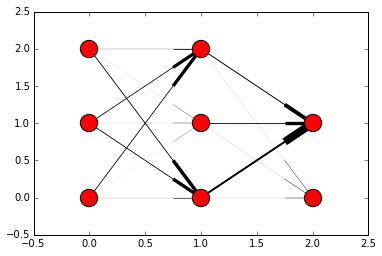

In [206]:
trainedGraph = kerasToGraph(model,layerNames)
plotForwardNeuralNet(trainedGraph,layerNames,weighted=True)

In [220]:
nx.pagerank(trainedGraph)

{'L1_0': 0.14729179694992722,
 'L1_1': 0.053847832389729386,
 'L1_2': 0.16237670107178254,
 'input_0': 0.065498609500934266,
 'input_1': 0.065498609500934266,
 'input_2': 0.065498609500934266,
 'output_0': 0.39828775219440349,
 'output_1': 0.041700088891354584}

## Util Functions

In [19]:
def graphAddLayer(graph, fromLayer,toLayer,connectionMatrix,threshhold=0,sep='_'):
    '''
    This method grows a graph according to non-zero connection matrix for to layers in a neural net
    This method takes as inputs:
    -a NetworkX object, graph
    -the name of the fromLayer and toLayer
    -a connection matrix of dimension fromLayer x toLayer
    and returns:
    -the grown graph
    '''
    fromNodeNames = list(map(lambda x: str(fromLayer) + sep + str(x),range(connectionMatrix.shape[0]))) #generate the names for the fromLayer
    toNodeNames = list(map(lambda x: str(toLayer) + sep + str(x),range(connectionMatrix.shape[1]))) #generate the names for the toLayer
    
    #add the nodes to the graph
    graph.add_nodes_from(fromNodeNames + toNodeNames)
    
    booleanMatrix = np.abs(connectionMatrix) > threshhold 
    
    #generate the edges
    edges = []
    for fromIX,fromNode in enumerate(fromNodeNames):
        for toIX,toNode in enumerate(toNodeNames):
            if(booleanMatrix[fromIX][toIX]):
                edges.append((fromNode,toNode, connectionMatrix[fromIX][toIX]))
    graph.add_weighted_edges_from(edges)
    
    return graph

In [18]:
def plotForwardNeuralNet(graph,layerNames,weighted=False, scaling= lambda x:x):
    '''
    This function returns a matplotlib object of a bipartite neural net
    It takes as input:
    -a NetworkX Graph
    -a list of layer names (could be deprecated with a regex but w/e)
    '''
    
    ##TODO: Make it return the Matplotlib object or figure isntead of automatically drawing
    
    listOfLayers = separateLayers(graph.nodes(),layerNames)
    positions = dict()
    for ix,layer in enumerate(listOfLayers):
        positions.update((n, (ix, i*(1-2*(i%2)))) for i, n in enumerate(layer))
    if weighted:
        nx.draw_networkx_nodes(graph,pos=positions) #draw the nodes
        #Loop through each edge 
        for (fromNode,toNode,weight) in graph.edges(data=True):
            nx.draw_networkx_edges(graph,positions,edgelist=[(fromNode,toNode)],width=scaling(weight['weight']))
    else:
        nx.draw(graph, pos=positions)

In [17]:
def kerasToGraph(model,layerNames,threshhold=0): #can change to list of threshholds or some methods or something
    '''
    This function converts a keras neural network to a NetworkX graph
    Inputs:
    -model, the keras model
    -layerNames, the list of layer names
    -threshhold(optional) - the absolute value above which the edge should be drawn
    '''
    graph = nx.DiGraph() #Use directed graph for now
    for ix,layerName in enumerate(layerNames):
        if ix >0:
            graph = graphAddLayer(graph,layerNames[ix-1],layerNames[ix],model.get_weights()[(ix-1)*2],threshhold)
    return(graph)
    

In [16]:
def separateLayers(listOfNodes,layerNames,sep='_'):
    """
    This function identifies the layers of a neural network based on the names of the layers
    Inputs:
    -a list of strings corresponding to nodes in a graph
    -a list of layer names
    Returns:
    -a list of lists with the names of nodes of each layer in a separate list
    """
    layers =[]
    for layer in layerNames:
        temp = []
        for node in listOfNodes:
            if re.search(layer+sep,node):
                temp.append(node)
        layers.append(temp)
    return layers

In [ ]:
def graphToKeras

In [2]:
layer_sizes = 10

In [10]:
layernames = ['input'] + ['L'+str(x) for x in range(layer_sizes-2)] + ['output']

In [28]:
a = ['%s to %s' % t for t in zip(layerNames[:-1], layerNames[1:])]

In [37]:
nx.algorithms.connectivity.node_connectivity.__name__

'node_connectivity'